### Required Imports

In [376]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, InputLayer
from keras.regularizers import l1, l2, l1_l2
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import mode

### Load and Unpickle Data Files

In [377]:
def load_and_unpickle(class_type, directory, subdirectory):
    """
    Description:
    Loads and Unpickles a file from the supplied parameters
    
    Parameter:
    class_type (str): class type to be loaded and unpickled\n
    directory (str): directory within the CWD\n
    subdirectory (str): subdirectory within the directory specified\n
    
    Returns:
    Specified dataframe if found in the directory\n
    None if not found\n
    """
    dir_path = f"{directory}/{subdirectory}"
    filename = f'{class_type}.pkl'
    filepath = os.path.join(dir_path, filename)

    if os.path.exists(filepath):
        df = pd.read_pickle(filepath)
        print(f"Loaded from {subdirectory} for class {class_type}")
        return df
    else:
        print(f"File not found: {filepath}")
        return None

### Get Dataframes from Loaded Files

In [378]:
def get_dataframes():
    classes = ["Jump", "Run", "Walk", "Squat"]
    clean_directory = "Clean"
    training_subdirectory = "Training"
    test_subdirectory = "Test"
    validation_subdirectory = "Validation"
    
    train_df_arr = []
    test_df_arr = []
    valid_df_arr = []
    
    complete_train_df = pd.DataFrame()
    complete_test_df = pd.DataFrame()
    complete_valid_df = pd.DataFrame()
    
    for class_type in classes:
        train_df_arr.append(load_and_unpickle(class_type, clean_directory, training_subdirectory))
        test_df_arr.append(load_and_unpickle(class_type, clean_directory, test_subdirectory))
        valid_df_arr.append(load_and_unpickle(class_type, clean_directory, validation_subdirectory))

    for train_df, test_df, valid_df in zip(train_df_arr, test_df_arr, valid_df_arr):
        complete_train_df = pd.concat([complete_train_df, train_df], ignore_index=True)
        complete_test_df = pd.concat([complete_test_df, test_df], ignore_index=True)
        complete_valid_df = pd.concat([complete_valid_df, valid_df], ignore_index=True)

    return complete_train_df, complete_test_df, complete_valid_df

clean_train_df, clean_test_df, clean_valid_df = get_dataframes()

Loaded from Training for class Jump
Loaded from Test for class Jump
Loaded from Validation for class Jump
Loaded from Training for class Run
Loaded from Test for class Run
Loaded from Validation for class Run
Loaded from Training for class Walk
Loaded from Test for class Walk
Loaded from Validation for class Walk
Loaded from Training for class Squat
Loaded from Test for class Squat
Loaded from Validation for class Squat


### Create Neural Network

In [379]:
def create_gru_neural_network(neurons, hidden_layers, timesteps):
    if(hidden_layers <= 0 or neurons <= 0 or timesteps <= 0):
        raise ValueError("args cannot be 0")
    
    model = Sequential()
    # Input Layer
    model.add(InputLayer(input_shape=(timesteps, 6), name="Input_Layer"))
    
    # Add Hidden layers
    for i in range(1, hidden_layers):
        model.add(GRU(neurons, activation='tanh', name=f"Hidden_layer_{i+1}_GRU", activity_regularizer=l1_l2(0.05, 0.1), return_sequences=True))
        model.add(Dropout(0.25))
   
    model.add(GRU(neurons, activation='tanh', name=f"Hidden_layer_GRU", activity_regularizer=l1_l2(0.05, 0.1)))
    model.add(Dropout(0.25))

    # Output Layer
    model.add(Dense(4, activation='softmax', name="Output_Layer"))
    # Compile Model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

### Train RNN Model

In [380]:
def train_gru_model(train_df, valid_df, neurons, hidden_layers, timesteps, batch_size=32, epochs=100):
    X_train = train_df[['ax', 'ay', 'az', 'gx', 'gy', 'gz']].values  # Feature columns
    Y_train = train_df['Class'].values  # Label column
    X_val = valid_df[['ax', 'ay', 'az', 'gx', 'gy', 'gz']].values # Feature columns
    Y_val = valid_df['Class'].values  # Label column

    # # Define the early stopping callback
    # early_stopping = EarlyStopping(
    #     monitor='val_loss',
    #     patience=10,
    #     verbose=1,
    #     restore_best_weights=True
    # )
    label_encoder = LabelEncoder()
    scaler = MinMaxScaler()

    # Normalize Data
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    #Encode Labels
    Y_train_encoded = label_encoder.fit_transform(Y_train)
    Y_val_encoded = label_encoder.transform(Y_val)

    #Reshape Data to fit into GRU layer (3D Array)
    num_samples_train = X_train.shape[0] // timesteps # get number of samples from train_df
    X_train = X_train[:num_samples_train * timesteps].reshape(num_samples_train, timesteps, 6)
    Y_train_encoded = Y_train_encoded[:num_samples_train * timesteps]
    Y_train_encoded = mode(Y_train_encoded.reshape(num_samples_train, timesteps), axis= 1)[0].flatten()

    num_samples_val = X_val.shape[0] // timesteps
    X_val = X_val[:num_samples_val * timesteps].reshape(num_samples_val, timesteps, 6)
    Y_val_encoded = Y_val_encoded[:num_samples_val * timesteps]
    Y_val_encoded = mode(Y_val_encoded.reshape(num_samples_val, timesteps), axis=1)[0].flatten()

    model = create_gru_neural_network(
        neurons=neurons,
        hidden_layers=hidden_layers,
        timesteps=timesteps
        )
    history = model.fit(
        x=X_train,
        y=Y_train_encoded,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_val, Y_val_encoded)
        # callbacks=[early_stopping]
    )

    return model, history, label_encoder


### Evaluate RNN Model with Test Dataset

In [381]:
def evaluate_model(test_df, model, label_encoder, timesteps):
    # Separate features and labels
    X_test = test_df[['ax', 'ay', 'az', 'gx', 'gy', 'gz']].values  # Feature columns
    Y_test = test_df['Class'].values  # Label column

    print(X_test.shape)
    print(Y_test.shape)

    scaler = MinMaxScaler()
    # Normalize Data
    X_test = scaler.fit_transform(X_test)

    #Encode Labels
    Y_test_encoded = label_encoder.transform(Y_test)

    # Reshape Data
    num_samples_test = X_test.shape[0] // timesteps  # Number of complete test sequences
    X_test = X_test[:num_samples_test * timesteps].reshape(num_samples_test, timesteps, 6)
    Y_test_encoded = Y_test_encoded[:num_samples_test * timesteps].reshape(num_samples_test, timesteps)  # Corresponding test labels
    Y_test_encoded = mode(Y_test_encoded, axis=1)[0].flatten()
    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, Y_test_encoded, verbose=1)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

### Plot Train and Validation Accuracy and Loss

In [382]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()
    plt.show()

### Plot Confusion Matrix

In [383]:
def plot_confusion_matrix(test_df, model, label_encoder, timesteps):
    # Separate features and labels
    X_test = test_df[['ax', 'ay', 'az', 'gx', 'gy', 'gz']].values  # Feature columns
    Y_test = test_df['Class'].values  # Label column

    scaler = MinMaxScaler()
    # Normalize Data using the pre-fitted scaler
    X_test = scaler.fit_transform(X_test)  # Use 'transform()' to prevent data leakage

    # Reshape Data for RNN (3D array)
    num_samples_test = X_test.shape[0] // timesteps  # Number of complete test sequences
    X_test = X_test[:num_samples_test * timesteps].reshape(num_samples_test, timesteps, 6)
    
    # Make predictions
    Y_pred_prob = model.predict(X_test)  # Get predicted probabilities
    Y_pred_encoded = np.argmax(Y_pred_prob, axis=1)  # Get predicted class indices

    # Reshape Y_test to match the predictions
    Y_test_encoded = label_encoder.transform(Y_test[:num_samples_test * timesteps])
    
    # Ensure Y_test_encoded is reshaped similarly
    Y_test_encoded = Y_test_encoded[:num_samples_test * timesteps].reshape(num_samples_test, timesteps)
    
    # Aggregate to get one label per sequence using mode
    Y_test_encoded = mode(Y_test_encoded, axis=1)[0].flatten()
    
    # Create confusion matrix
    cm = confusion_matrix(Y_test_encoded, Y_pred_encoded)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=label_encoder.classes_,  # Use original class names for axis
                yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


### 16 Neurons | 1 Hidden Layer | 10 Timesteps

In [ ]:
model_16_1_10, history_16_1_10, label_encoder_16_1_10 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=16,
    hidden_layers=1,
    timesteps=10
)
plot_training_history(
    history_16_1_10
)
evaluate_model(
    test_df=clean_test_df,
    model=model_16_1_10,
    label_encoder=label_encoder_16_1_10,
    timesteps=10
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_16_1_10,
    label_encoder=label_encoder_16_1_10,
    timesteps = 10
)

### 16 Neurons | 1 Hidden Layer | 20 Timesteps

Model: "sequential_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_GRU (GRU)      (None, 16)                1152      
                                                                 
 dropout_185 (Dropout)       (None, 16)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 68        
                                                                 
Total params: 1,220
Trainable params: 1,220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 2s 26ms/step - loss: 1.6696 - accuracy: 0.2545 - val_loss: 1.5799 - val_accuracy: 0.2710
Epoch 2/100
25/25 [==============================] - 0s 8ms/step - loss: 1.5240 - accuracy: 0.2659 - val_loss: 1.4910 - val_accuracy: 0.2290
Epoch 3/100
25/25 [============

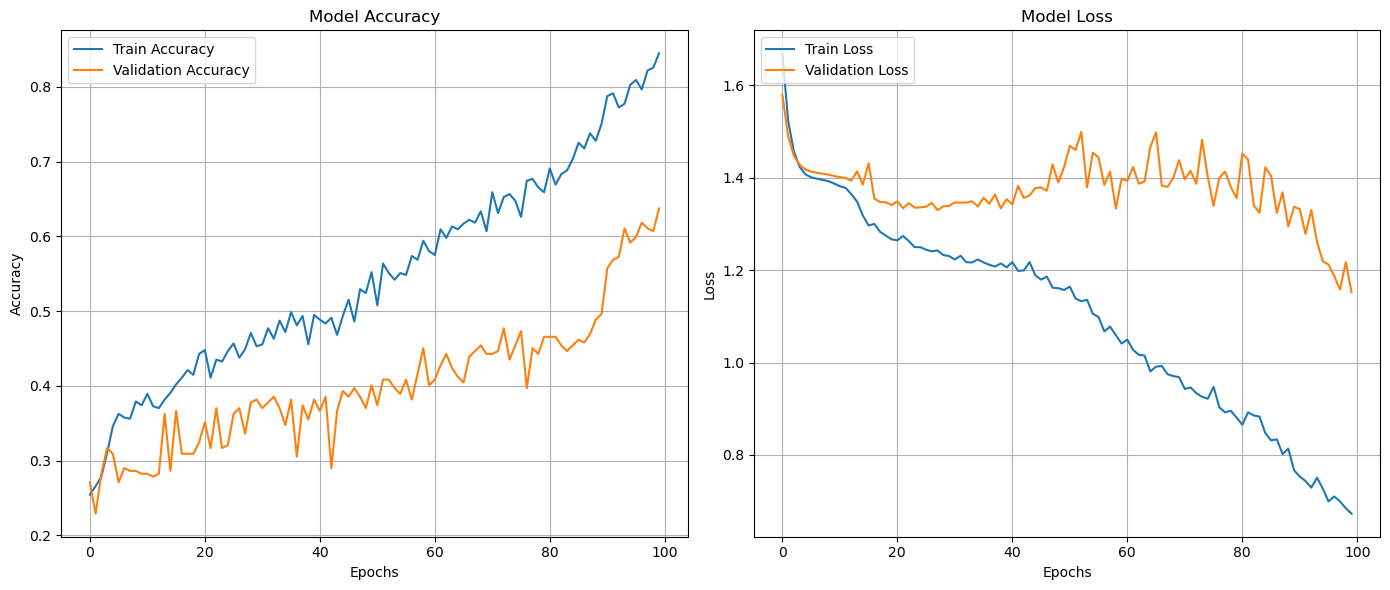

(5245, 6)
(5245,)
9/9 [==============================] - 0s 2ms/step - loss: 0.7009 - accuracy: 0.8244
Test Loss: 0.7009
Test Accuracy: 0.8244
9/9 [==============================] - 0s 2ms/step


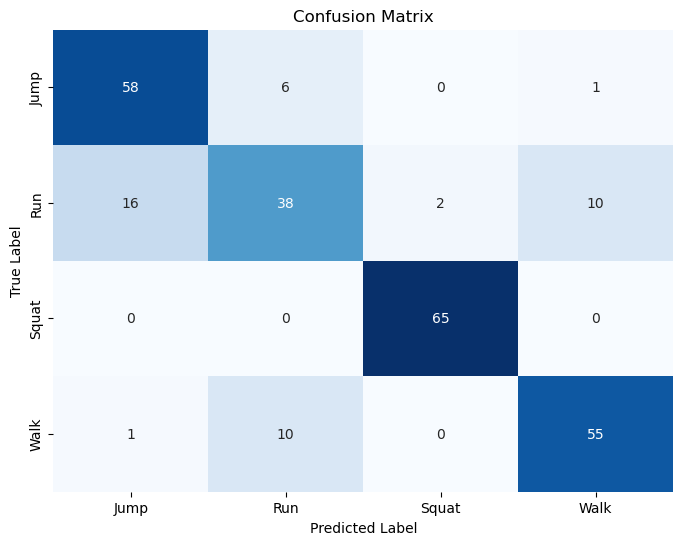

In [385]:
model_16_1_20, history_16_1_20, label_encoder_16_1_20 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=16,
    hidden_layers=1,
    timesteps=20
)
plot_training_history(
    history_16_1_20
)
evaluate_model(
    test_df=clean_test_df,
    model=model_16_1_20,
    label_encoder=label_encoder_16_1_20,
    timesteps=20
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_16_1_20,
    label_encoder=label_encoder_16_1_20,
    timesteps = 20
)

### 16 Neurons | 1 Hidden Layer | 30 Timesteps

Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_GRU (GRU)      (None, 16)                1152      
                                                                 
 dropout_186 (Dropout)       (None, 16)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 68        
                                                                 
Total params: 1,220
Trainable params: 1,220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
17/17 [==============================] - 2s 39ms/step - loss: 1.6988 - accuracy: 0.2653 - val_loss: 1.5970 - val_accuracy: 0.2471
Epoch 2/100
17/17 [==============================] - 0s 11ms/step - loss: 1.5820 - accuracy: 0.2882 - val_loss: 1.5235 - val_accuracy: 0.2586
Epoch 3/100
17/17 [===========

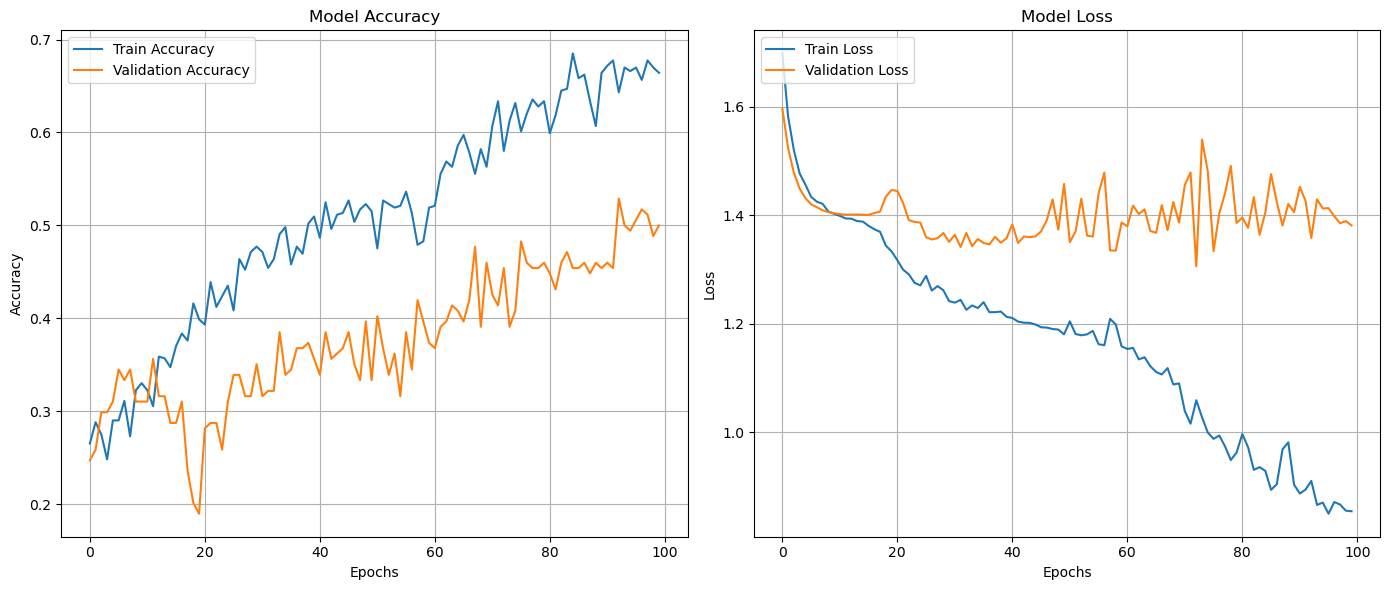

(5245, 6)
(5245,)
6/6 [==============================] - 0s 3ms/step - loss: 1.0277 - accuracy: 0.6264
Test Loss: 1.0277
Test Accuracy: 0.6264
6/6 [==============================] - 0s 3ms/step


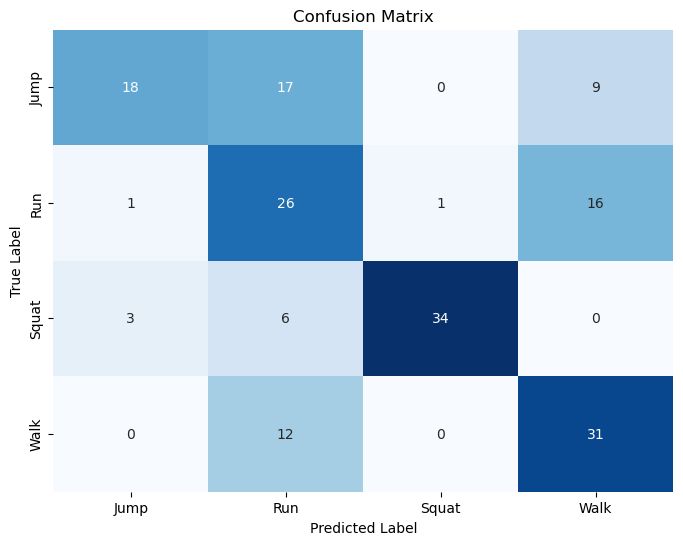

In [386]:
model_16_1_30, history_16_1_30, label_encoder_16_1_30 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=16,
    hidden_layers=1,
    timesteps=30
)
plot_training_history(
    history_16_1_30
)
evaluate_model(
    test_df=clean_test_df,
    model=model_16_1_30,
    label_encoder=label_encoder_16_1_30,
    timesteps=30
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_16_1_30,
    label_encoder=label_encoder_16_1_30,
    timesteps = 30
)

### 16 Neurons | 2 Hidden Layer | 10 Timesteps

Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_2_GRU (GRU)    (None, 10, 16)            1152      
                                                                 
 dropout_187 (Dropout)       (None, 10, 16)            0         
                                                                 
 Hidden_layer_GRU (GRU)      (None, 16)                1632      
                                                                 
 dropout_188 (Dropout)       (None, 16)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 68        
                                                                 
Total params: 2,852
Trainable params: 2,852
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
50/50 [==============================]

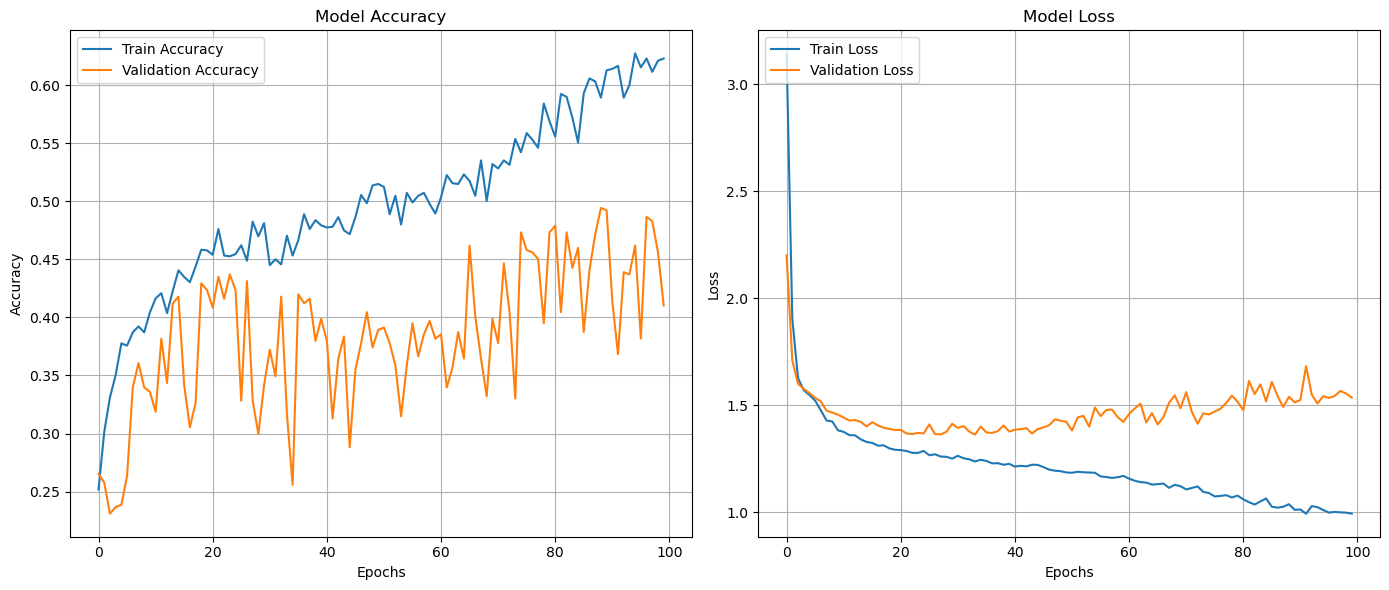

(5245, 6)
(5245,)
17/17 [==============================] - 0s 2ms/step - loss: 0.8713 - accuracy: 0.7099
Test Loss: 0.8713
Test Accuracy: 0.7099
17/17 [==============================] - 1s 3ms/step


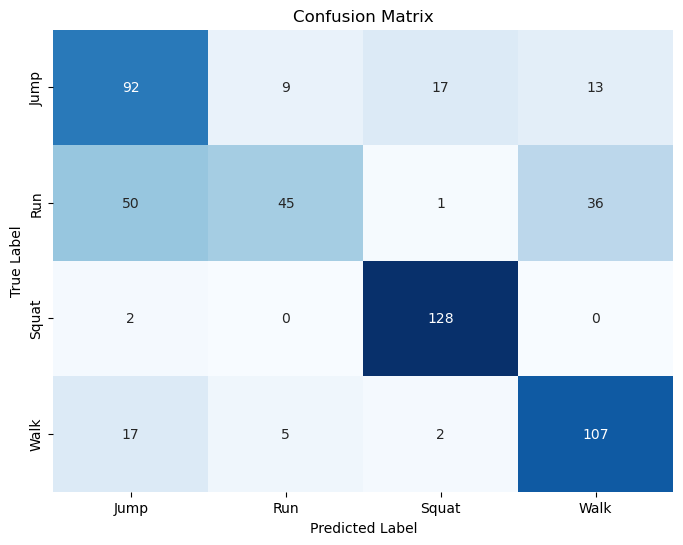

In [387]:
model_16_2_10, history_16_2_10, label_encoder_16_2_10 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=16,
    hidden_layers=2,
    timesteps=10
)
plot_training_history(
    history_16_2_10
)
evaluate_model(
    test_df=clean_test_df,
    model=model_16_2_10,
    label_encoder=label_encoder_16_2_10,
    timesteps=10
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_16_2_10,
    label_encoder=label_encoder_16_2_10,
    timesteps = 10
)

### 16 Neurons | 2 Hidden Layer | 20 Timesteps

Model: "sequential_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_2_GRU (GRU)    (None, 20, 16)            1152      
                                                                 
 dropout_189 (Dropout)       (None, 20, 16)            0         
                                                                 
 Hidden_layer_GRU (GRU)      (None, 16)                1632      
                                                                 
 dropout_190 (Dropout)       (None, 16)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 68        
                                                                 
Total params: 2,852
Trainable params: 2,852
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================]

Exception ignored in: <function UniquePtr.__del__ at 0x000001EC91846820>
Traceback (most recent call last):
  File "c:\Users\Talal\anaconda3\envs\Lab\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 71, in __del__
    obj = self._obj
AttributeError: _obj


25/25 [==============================] - 6s 112ms/step - loss: 7.0221 - accuracy: 0.2239 - val_loss: 5.2846 - val_accuracy: 0.1832
Epoch 2/100
25/25 [==============================] - 0s 14ms/step - loss: 4.3191 - accuracy: 0.2061 - val_loss: 3.4821 - val_accuracy: 0.1870
Epoch 3/100
25/25 [==============================] - 0s 15ms/step - loss: 2.9795 - accuracy: 0.2379 - val_loss: 2.5668 - val_accuracy: 0.2519
Epoch 4/100
25/25 [==============================] - 0s 14ms/step - loss: 2.2707 - accuracy: 0.2494 - val_loss: 2.0764 - val_accuracy: 0.2099
Epoch 5/100
25/25 [==============================] - 0s 14ms/step - loss: 1.9088 - accuracy: 0.2494 - val_loss: 1.8543 - val_accuracy: 0.2023
Epoch 6/100
25/25 [==============================] - 0s 14ms/step - loss: 1.7976 - accuracy: 0.2303 - val_loss: 1.8145 - val_accuracy: 0.2061
Epoch 7/100
25/25 [==============================] - 0s 14ms/step - loss: 1.7708 - accuracy: 0.2672 - val_loss: 1.7954 - val_accuracy: 0.2099
Epoch 8/100
25/25

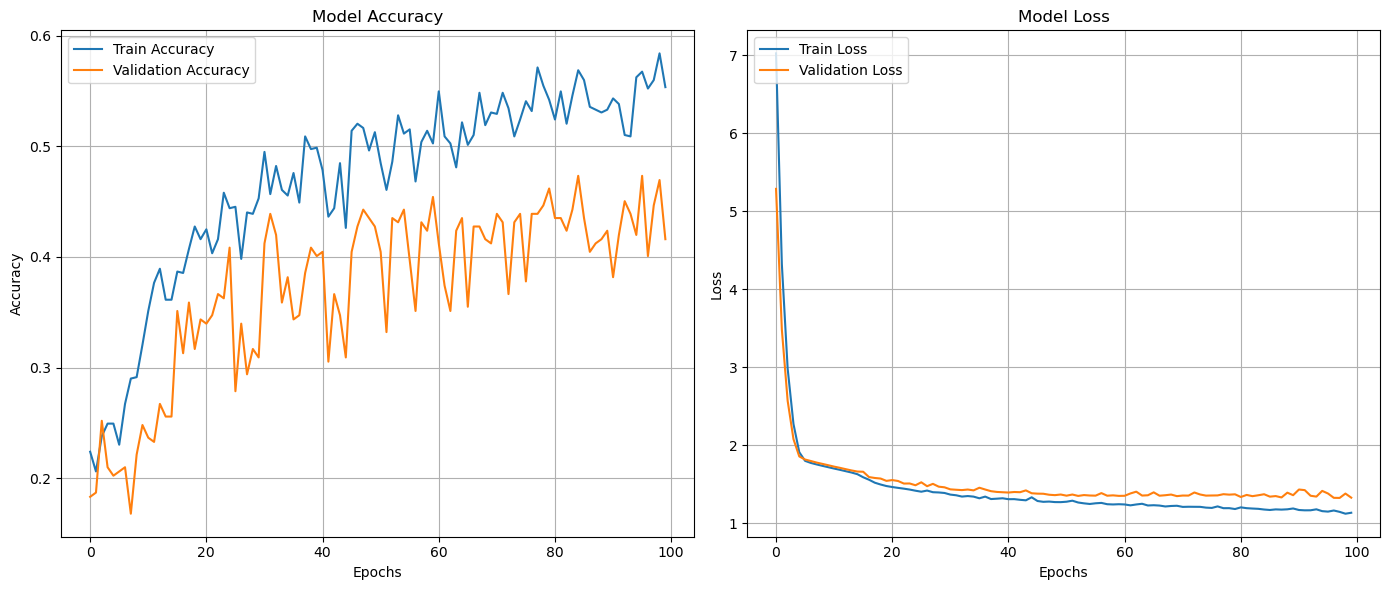

(5245, 6)
(5245,)
9/9 [==============================] - 0s 4ms/step - loss: 1.1227 - accuracy: 0.5000
Test Loss: 1.1227
Test Accuracy: 0.5000
9/9 [==============================] - 1s 4ms/step


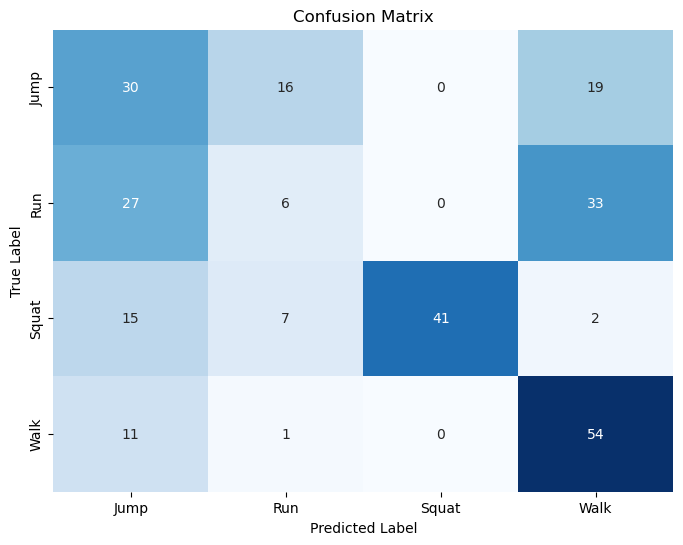

In [388]:
model_16_2_20, history_16_2_20, label_encoder_16_2_20 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=16,
    hidden_layers=2,
    timesteps=20
)
plot_training_history(
    history_16_2_20
)
evaluate_model(
    test_df=clean_test_df,
    model=model_16_2_20,
    label_encoder=label_encoder_16_2_20,
    timesteps=20
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_16_2_20,
    label_encoder=label_encoder_16_2_20,
    timesteps = 20
)

### 16 Neurons | 2 Hidden Layer | 30 Timesteps

Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_2_GRU (GRU)    (None, 30, 16)            1152      
                                                                 
 dropout_191 (Dropout)       (None, 30, 16)            0         
                                                                 
 Hidden_layer_GRU (GRU)      (None, 16)                1632      
                                                                 
 dropout_192 (Dropout)       (None, 16)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 68        
                                                                 
Total params: 2,852
Trainable params: 2,852
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
17/17 [==============================]

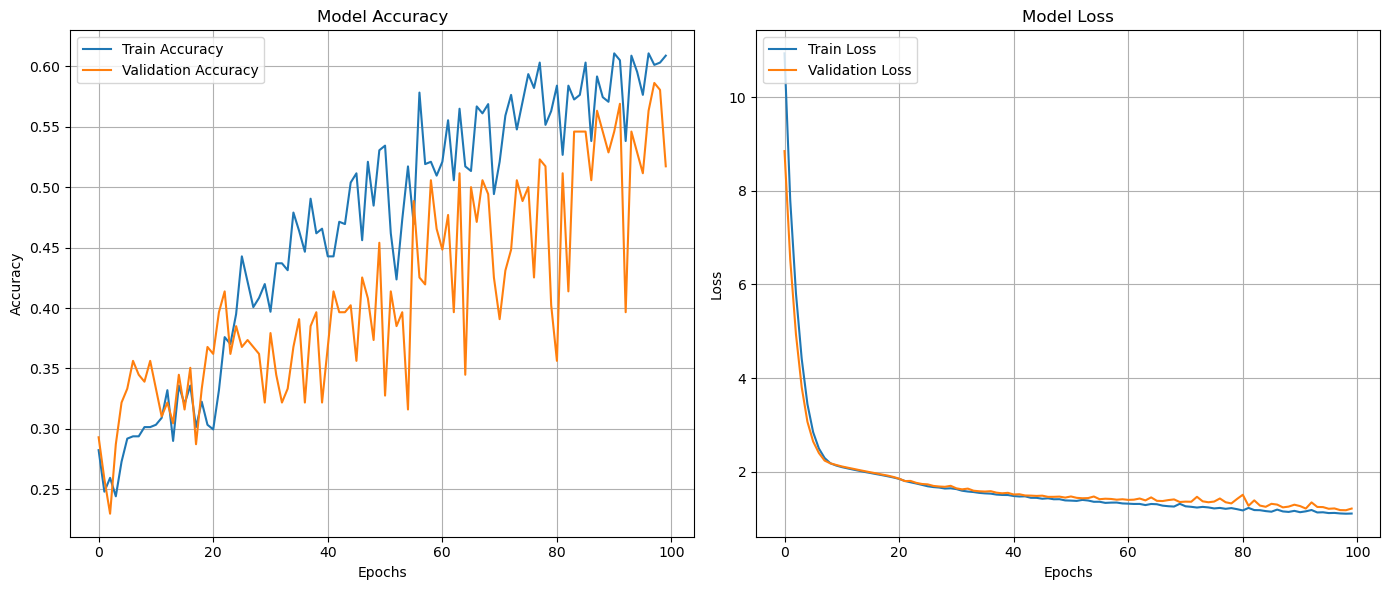

(5245, 6)
(5245,)
6/6 [==============================] - 0s 6ms/step - loss: 1.0802 - accuracy: 0.6552
Test Loss: 1.0802
Test Accuracy: 0.6552
6/6 [==============================] - 1s 5ms/step


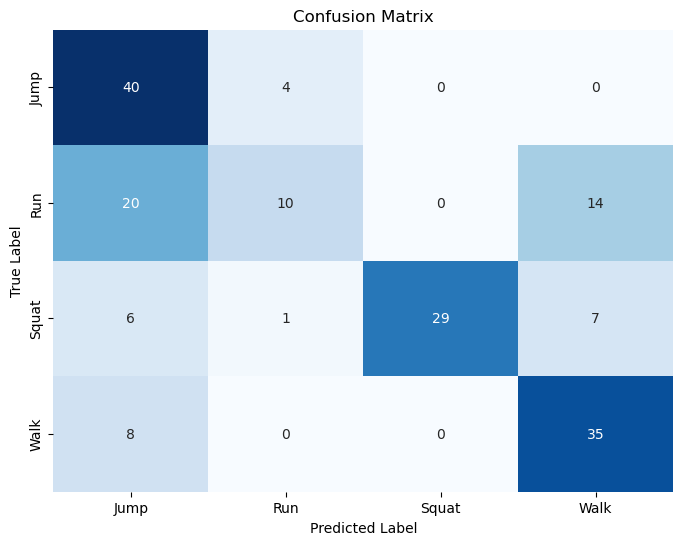

In [389]:
model_16_2_30, history_16_2_30, label_encoder_16_2_30 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=16,
    hidden_layers=2,
    timesteps=30
)
plot_training_history(
    history_16_2_30
)
evaluate_model(
    test_df=clean_test_df,
    model=model_16_2_30,
    label_encoder=label_encoder_16_2_30,
    timesteps=30
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_16_2_30,
    label_encoder=label_encoder_16_2_30,
    timesteps = 30
)

### 32 Neurons | 1 Hidden Layer | 10 Timesteps

Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_GRU (GRU)      (None, 32)                3840      
                                                                 
 dropout_193 (Dropout)       (None, 32)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 132       
                                                                 
Total params: 3,972
Trainable params: 3,972
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
50/50 [==============================] - 2s 14ms/step - loss: 1.5300 - accuracy: 0.2734 - val_loss: 1.4528 - val_accuracy: 0.2118
Epoch 2/100
50/50 [==============================] - 0s 5ms/step - loss: 1.4275 - accuracy: 0.3617 - val_loss: 1.4265 - val_accuracy: 0.2500
Epoch 3/100
50/50 [============

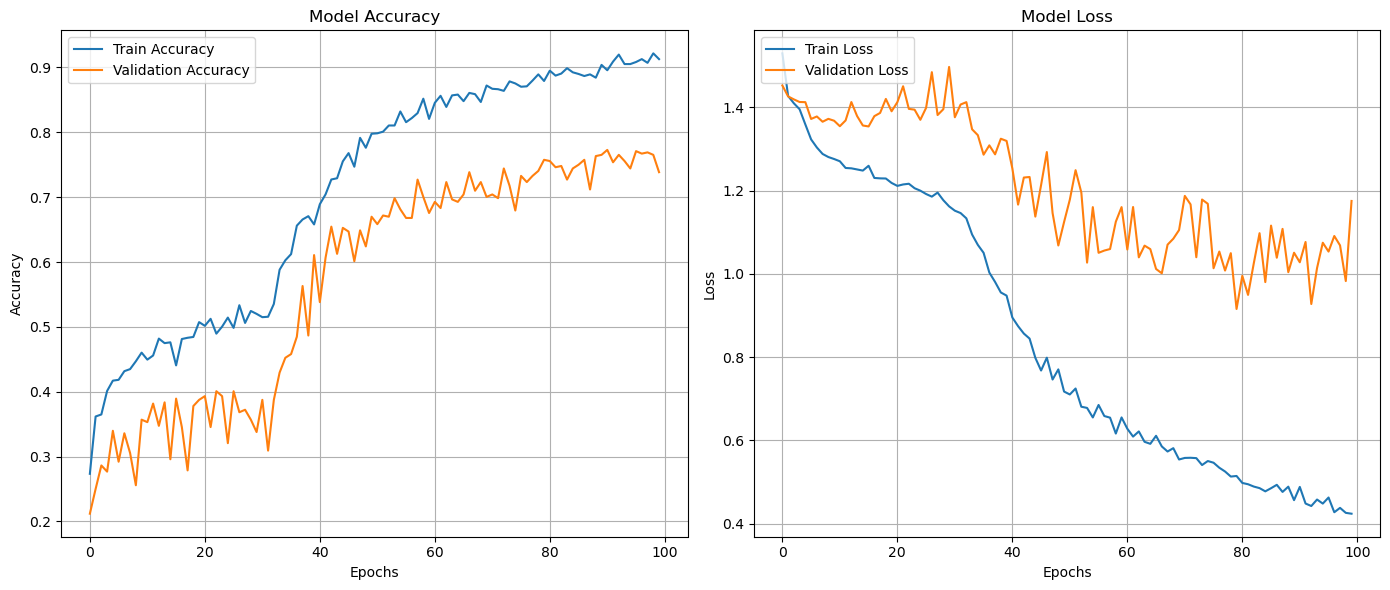

(5245, 6)
(5245,)
17/17 [==============================] - 0s 2ms/step - loss: 0.6488 - accuracy: 0.8225
Test Loss: 0.6488
Test Accuracy: 0.8225
17/17 [==============================] - 0s 1ms/step


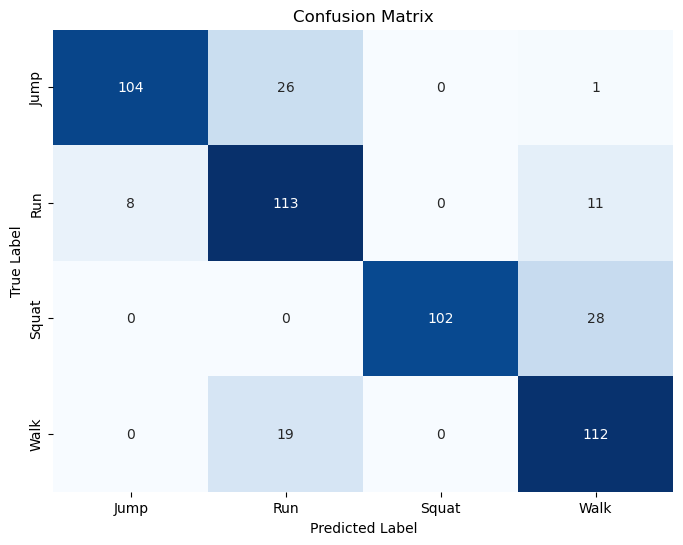

In [390]:
model_32_1_10, history_32_1_10, label_encoder_32_1_10 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=32,
    hidden_layers=1,
    timesteps=10
)
plot_training_history(
    history_32_1_10
)
evaluate_model(
    test_df=clean_test_df,
    model=model_32_1_10,
    label_encoder=label_encoder_32_1_10,
    timesteps=10
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_32_1_10,
    label_encoder=label_encoder_32_1_10,
    timesteps = 10
)

### 32 Neurons | 1 Hidden Layer | 20 Timesteps

Model: "sequential_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_GRU (GRU)      (None, 32)                3840      
                                                                 
 dropout_194 (Dropout)       (None, 32)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 132       
                                                                 
Total params: 3,972
Trainable params: 3,972
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 2s 27ms/step - loss: 1.7252 - accuracy: 0.2557 - val_loss: 1.5892 - val_accuracy: 0.2252
Epoch 2/100
25/25 [==============================] - 0s 8ms/step - loss: 1.5615 - accuracy: 0.2303 - val_loss: 1.5085 - val_accuracy: 0.1908
Epoch 3/100
25/25 [============

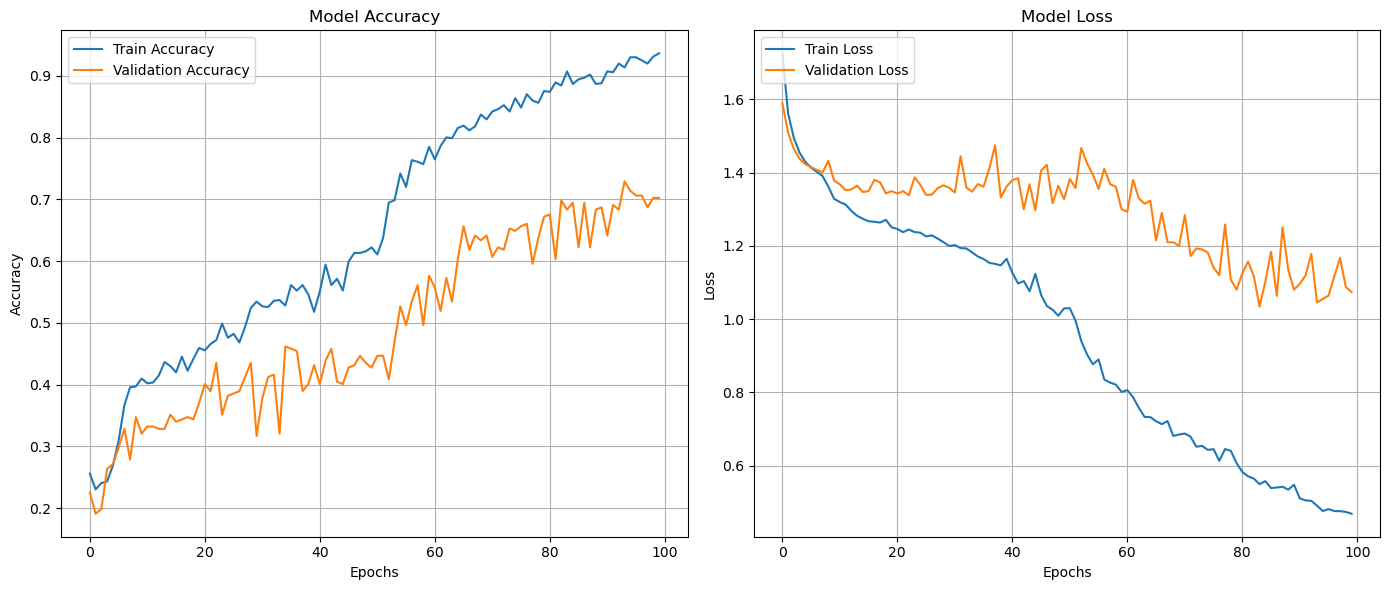

(5245, 6)
(5245,)
9/9 [==============================] - 0s 2ms/step - loss: 0.6411 - accuracy: 0.8282
Test Loss: 0.6411
Test Accuracy: 0.8282
9/9 [==============================] - 0s 2ms/step


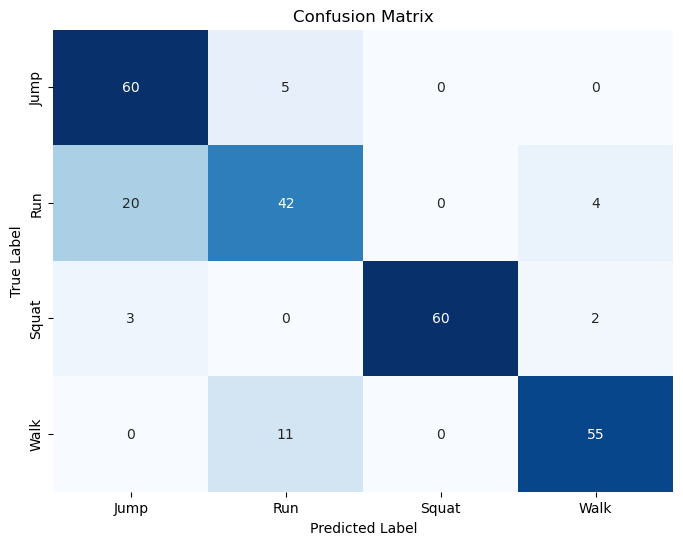

In [391]:
model_32_1_20, history_32_1_20, label_encoder_32_1_20 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=32,
    hidden_layers=1,
    timesteps=20
)
plot_training_history(
    history_32_1_20
)
evaluate_model(
    test_df=clean_test_df,
    model=model_32_1_20,
    label_encoder=label_encoder_32_1_20,
    timesteps=20
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_32_1_20,
    label_encoder=label_encoder_32_1_20,
    timesteps = 20
)

### 32 Neurons | 1 Hidden Layer | 30 Timesteps

Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_GRU (GRU)      (None, 32)                3840      
                                                                 
 dropout_195 (Dropout)       (None, 32)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 132       
                                                                 
Total params: 3,972
Trainable params: 3,972
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
17/17 [==============================] - 2s 39ms/step - loss: 1.7145 - accuracy: 0.2385 - val_loss: 1.6129 - val_accuracy: 0.2529
Epoch 2/100
17/17 [==============================] - 0s 11ms/step - loss: 1.5734 - accuracy: 0.2748 - val_loss: 1.5301 - val_accuracy: 0.2126
Epoch 3/100
17/17 [===========

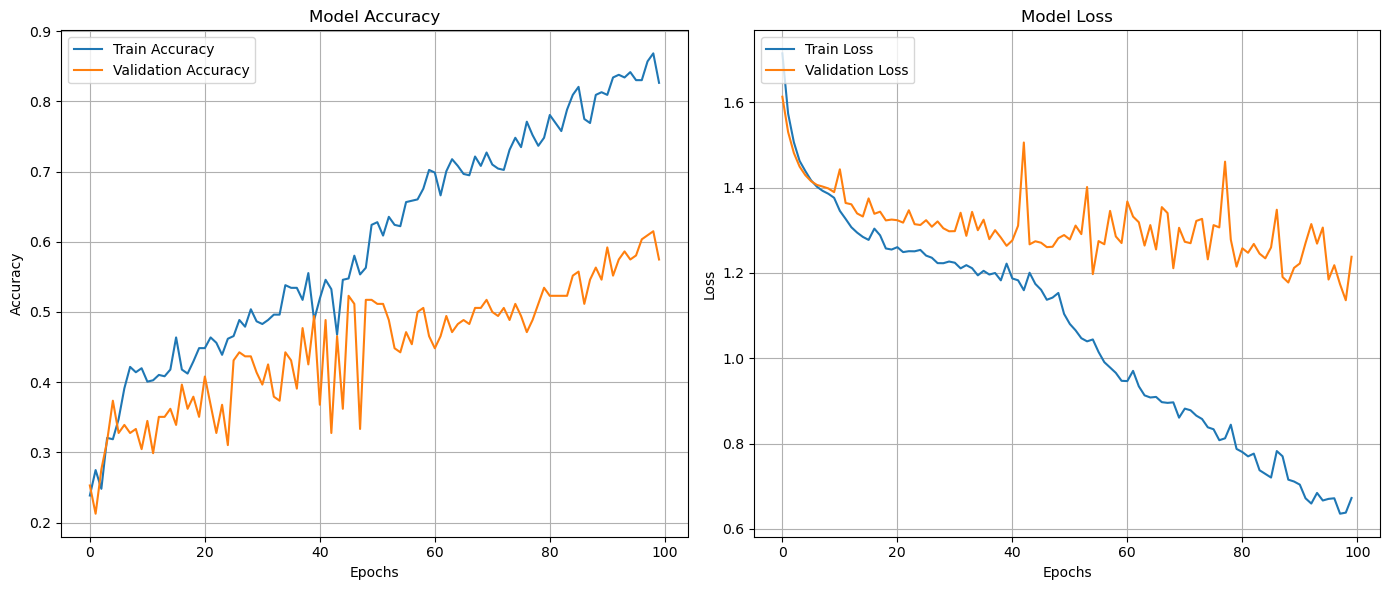

(5245, 6)
(5245,)
6/6 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.8736
Test Loss: 0.6492
Test Accuracy: 0.8736
6/6 [==============================] - 0s 3ms/step


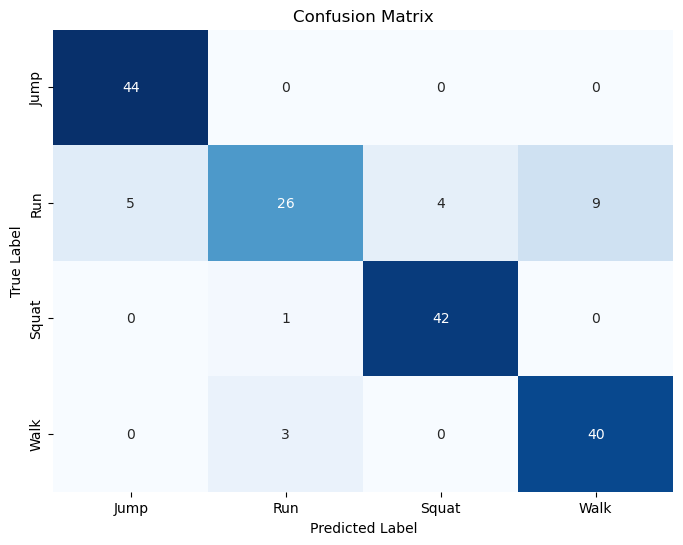

In [392]:
model_32_1_30, history_32_1_30, label_encoder_32_1_30 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=32,
    hidden_layers=1,
    timesteps=30
)
plot_training_history(
    history_32_1_30
)
evaluate_model(
    test_df=clean_test_df,
    model=model_32_1_30,
    label_encoder=label_encoder_32_1_30,
    timesteps=30
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_32_1_30,
    label_encoder=label_encoder_32_1_30,
    timesteps = 30
)

### 32 Neurons | 2 Hidden Layer | 10 Timesteps

Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_2_GRU (GRU)    (None, 10, 32)            3840      
                                                                 
 dropout_196 (Dropout)       (None, 10, 32)            0         
                                                                 
 Hidden_layer_GRU (GRU)      (None, 32)                6336      
                                                                 
 dropout_197 (Dropout)       (None, 32)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 132       
                                                                 
Total params: 10,308
Trainable params: 10,308
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
50/50 [=============================

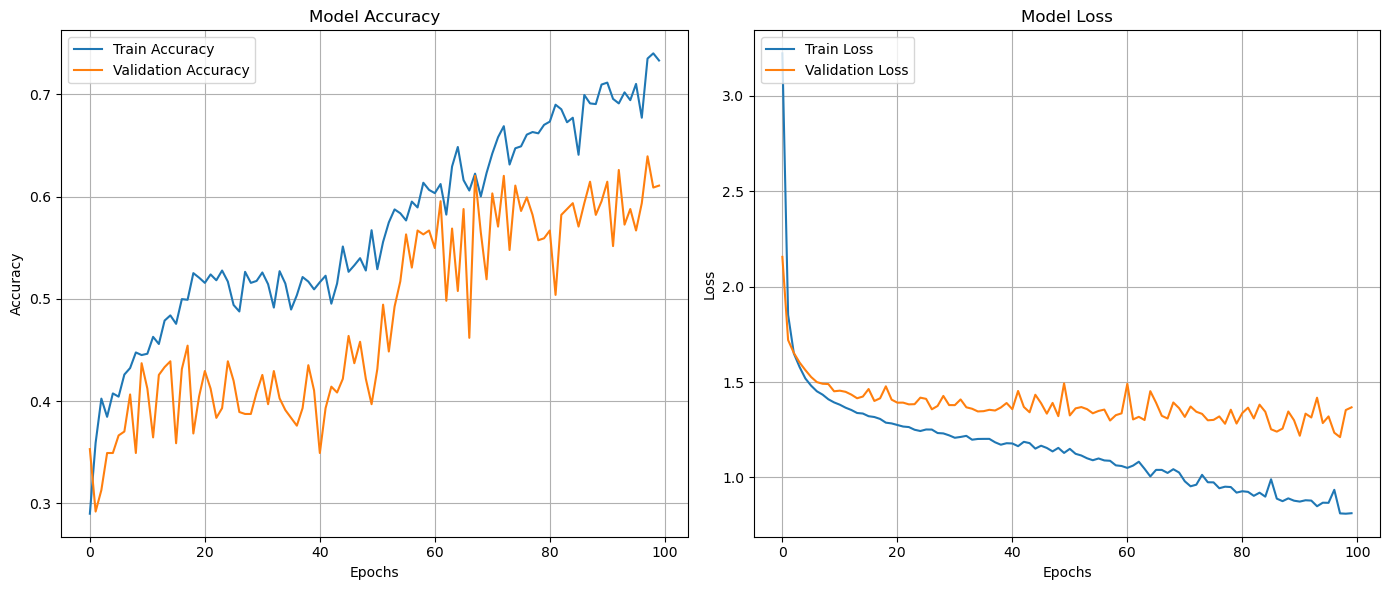

(5245, 6)
(5245,)
17/17 [==============================] - 0s 3ms/step - loss: 0.9213 - accuracy: 0.6489
Test Loss: 0.9213
Test Accuracy: 0.6489
17/17 [==============================] - 1s 3ms/step


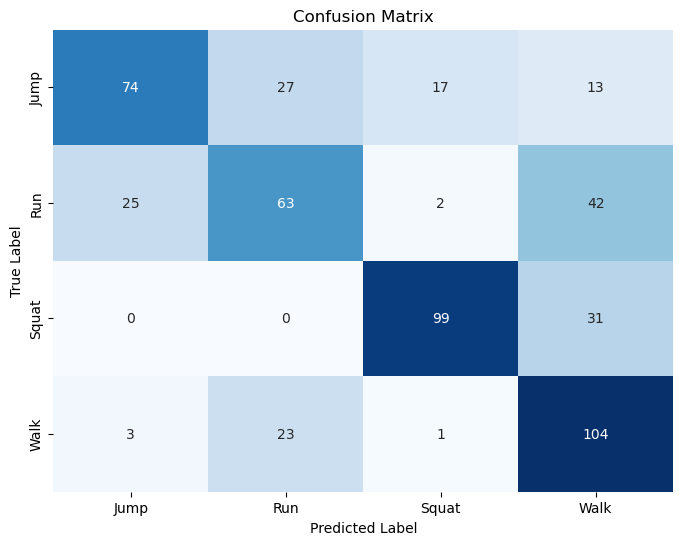

In [393]:
model_32_2_10, history_32_2_10, label_encoder_32_2_10 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=32,
    hidden_layers=2,
    timesteps=10
)
plot_training_history(
    history_32_2_10
)
evaluate_model(
    test_df=clean_test_df,
    model=model_32_2_10,
    label_encoder=label_encoder_32_2_10,
    timesteps=10
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_32_2_10,
    label_encoder=label_encoder_32_2_10,
    timesteps = 10
)

### 32 Neurons | 2 Hidden Layer | 20 Timesteps

Model: "sequential_146"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_2_GRU (GRU)    (None, 20, 32)            3840      
                                                                 
 dropout_198 (Dropout)       (None, 20, 32)            0         
                                                                 
 Hidden_layer_GRU (GRU)      (None, 32)                6336      
                                                                 
 dropout_199 (Dropout)       (None, 32)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 132       
                                                                 
Total params: 10,308
Trainable params: 10,308
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [=============================

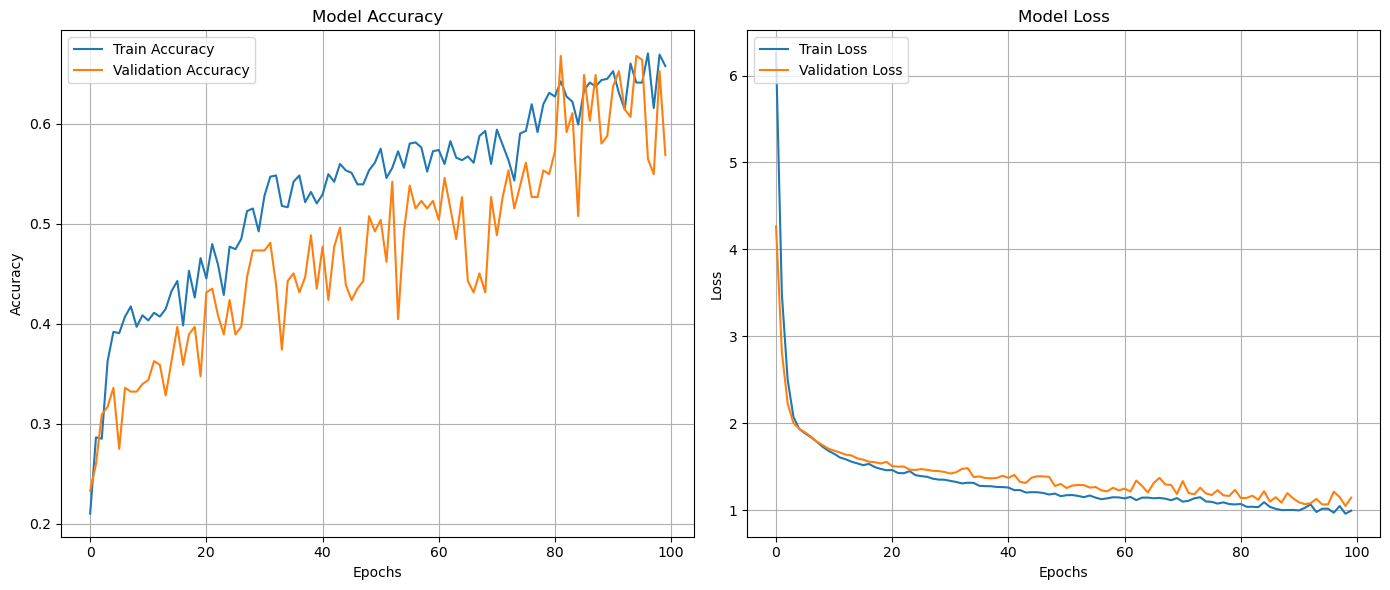

(5245, 6)
(5245,)
9/9 [==============================] - 0s 4ms/step - loss: 0.9247 - accuracy: 0.6603
Test Loss: 0.9247
Test Accuracy: 0.6603
9/9 [==============================] - 1s 4ms/step


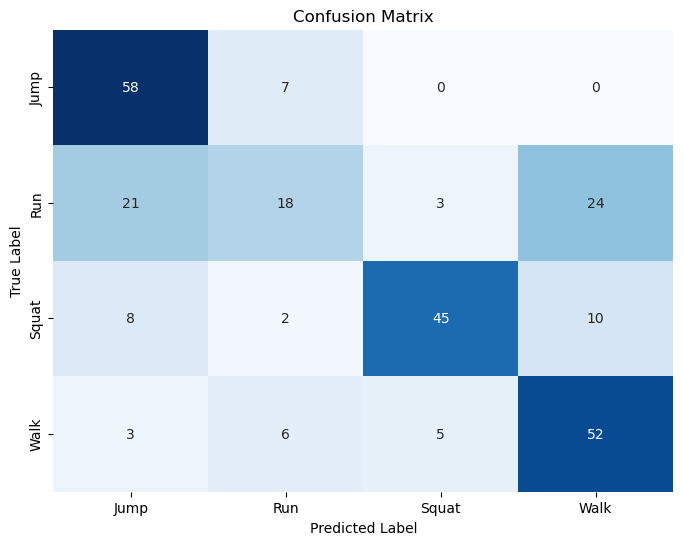

In [394]:
model_32_2_20, history_32_2_20, label_encoder_32_2_20 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=32,
    hidden_layers=2,
    timesteps=20
)
plot_training_history(
    history_32_2_20
)
evaluate_model(
    test_df=clean_test_df,
    model=model_32_2_20,
    label_encoder=label_encoder_32_2_20,
    timesteps=20
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_32_2_20,
    label_encoder=label_encoder_32_2_20,
    timesteps = 20
)

### 32 Neurons | 2 Hidden Layer | 30 Timesteps

Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_2_GRU (GRU)    (None, 30, 32)            3840      
                                                                 
 dropout_200 (Dropout)       (None, 30, 32)            0         
                                                                 
 Hidden_layer_GRU (GRU)      (None, 32)                6336      
                                                                 
 dropout_201 (Dropout)       (None, 32)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 132       
                                                                 
Total params: 10,308
Trainable params: 10,308
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
17/17 [=============================

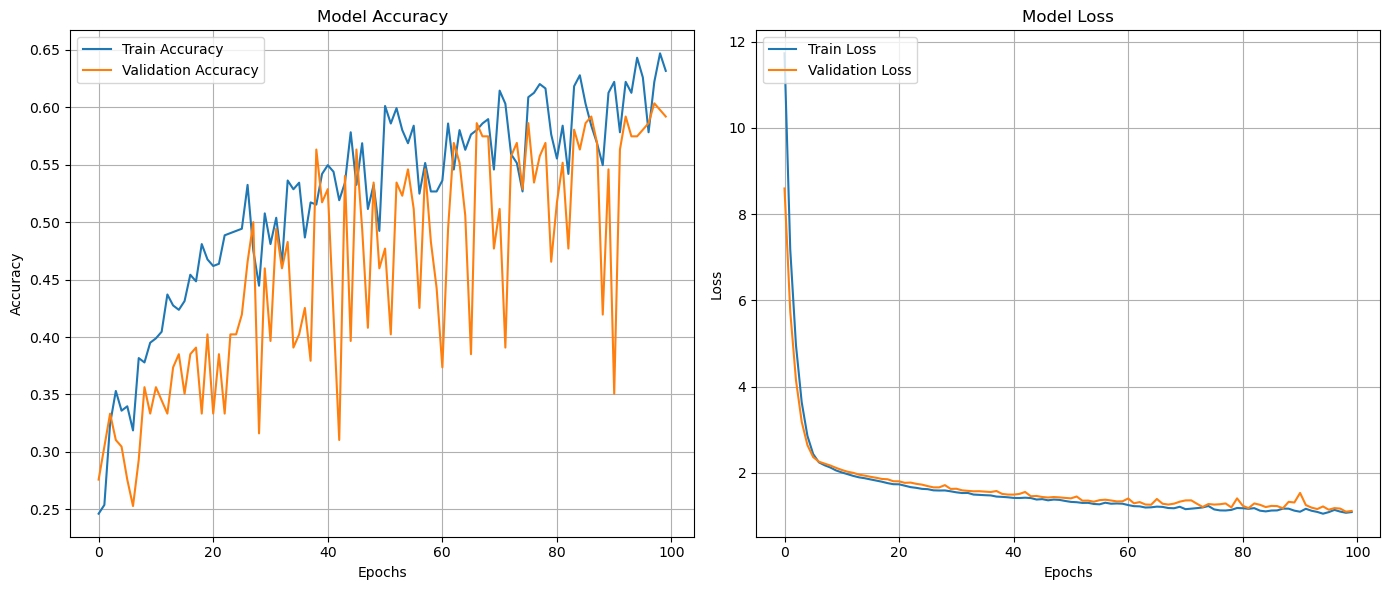

(5245, 6)
(5245,)
6/6 [==============================] - 0s 8ms/step - loss: 1.3233 - accuracy: 0.4368
Test Loss: 1.3233
Test Accuracy: 0.4368
6/6 [==============================] - 1s 6ms/step


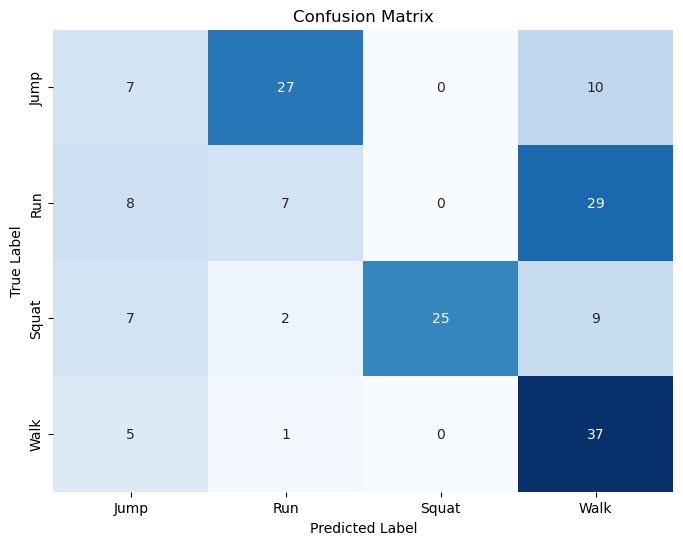

In [395]:
model_32_2_30, history_32_2_30, label_encoder_32_2_30 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=32,
    hidden_layers=2,
    timesteps=30
)
plot_training_history(
    history_32_2_30
)
evaluate_model(
    test_df=clean_test_df,
    model=model_32_2_30,
    label_encoder=label_encoder_32_2_30,
    timesteps=30
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_32_2_30,
    label_encoder=label_encoder_32_2_30,
    timesteps = 30
)

### 64 Neurons | 1 Hidden Layer | 10 Timesteps

Model: "sequential_148"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_GRU (GRU)      (None, 64)                13824     
                                                                 
 dropout_202 (Dropout)       (None, 64)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 260       
                                                                 
Total params: 14,084
Trainable params: 14,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
50/50 [==============================] - 2s 15ms/step - loss: 1.6016 - accuracy: 0.2479 - val_loss: 1.4565 - val_accuracy: 0.2844
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: 1.4318 - accuracy: 0.3312 - val_loss: 1.4228 - val_accuracy: 0.3397
Epoch 3/100
50/50 [==========

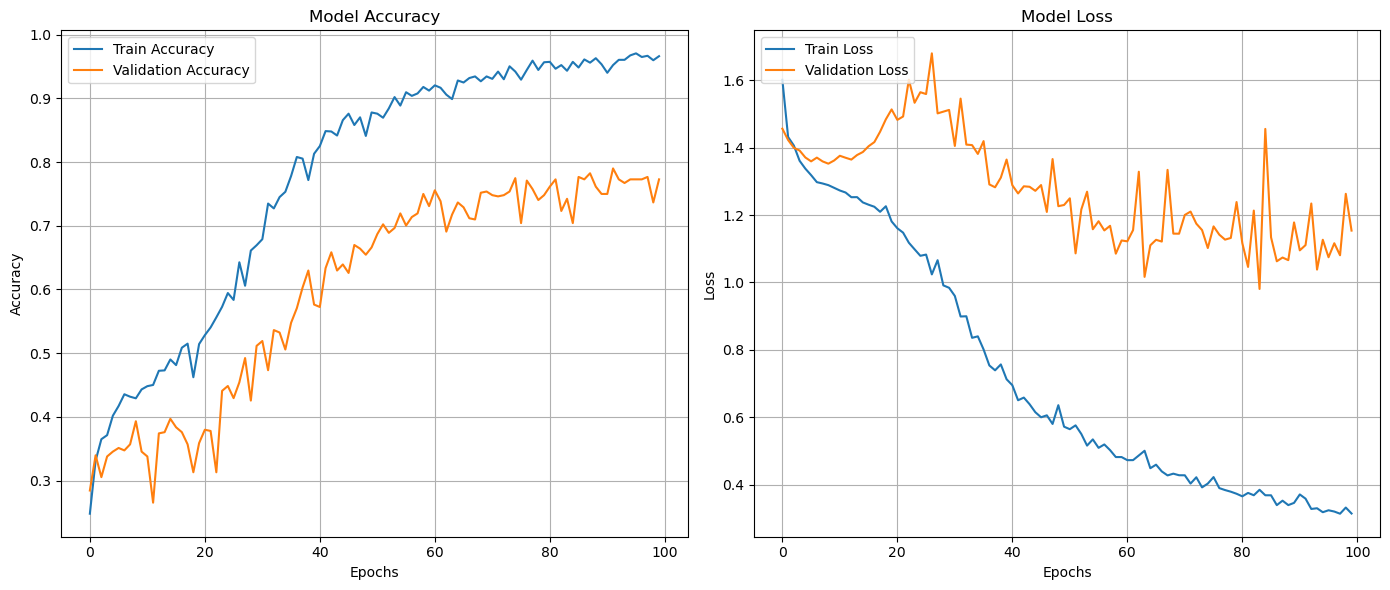

(5245, 6)
(5245,)
17/17 [==============================] - 0s 2ms/step - loss: 0.6762 - accuracy: 0.8378
Test Loss: 0.6762
Test Accuracy: 0.8378
17/17 [==============================] - 0s 2ms/step


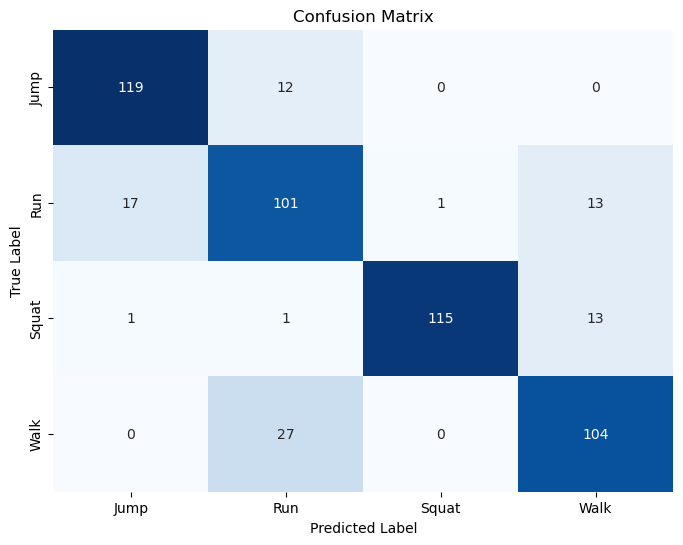

In [396]:
model_64_1_10, history_64_1_10, label_encoder_64_1_10 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=64,
    hidden_layers=1,
    timesteps=10
)
plot_training_history(
    history_64_1_10
)
evaluate_model(
    test_df=clean_test_df,
    model=model_64_1_10,
    label_encoder=label_encoder_64_1_10,
    timesteps=10
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_64_1_10,
    label_encoder=label_encoder_64_1_10,
    timesteps = 10
)

### 64 Neurons | 1 Hidden Layer | 20 Timesteps

Model: "sequential_149"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_GRU (GRU)      (None, 64)                13824     
                                                                 
 dropout_203 (Dropout)       (None, 64)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 260       
                                                                 
Total params: 14,084
Trainable params: 14,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 2s 28ms/step - loss: 1.6438 - accuracy: 0.2417 - val_loss: 1.5107 - val_accuracy: 0.3206
Epoch 2/100
25/25 [==============================] - 0s 10ms/step - loss: 1.4754 - accuracy: 0.2799 - val_loss: 1.4416 - val_accuracy: 0.3855
Epoch 3/100
25/25 [=========

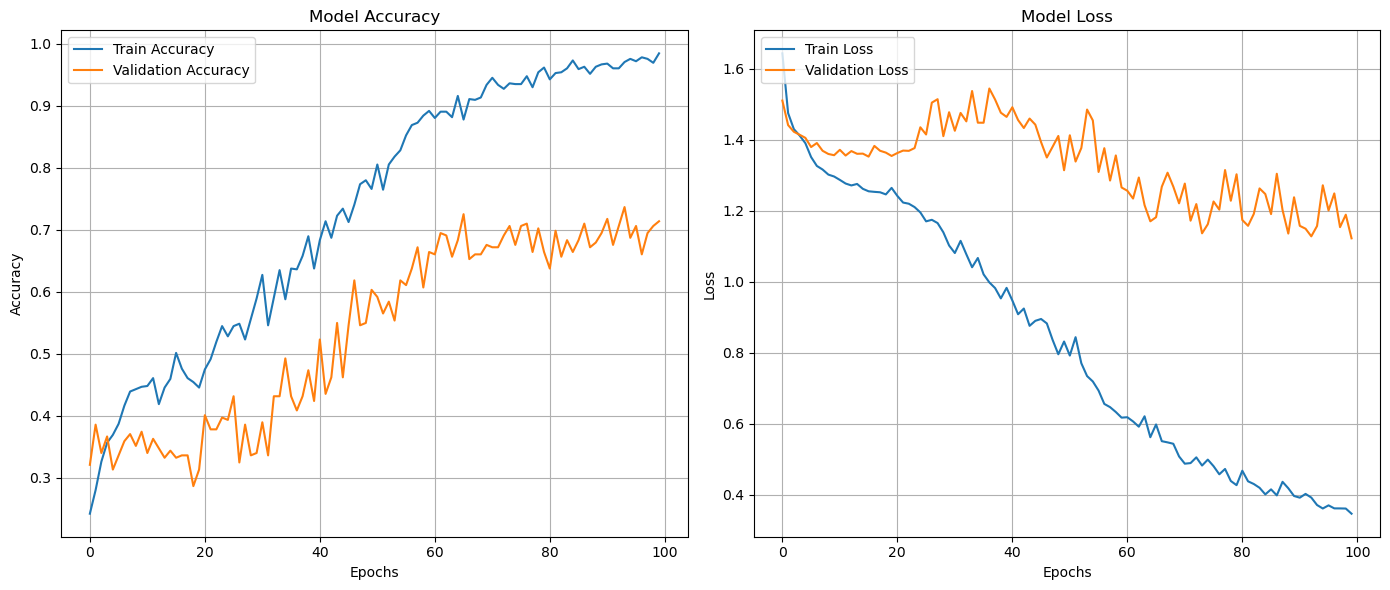

(5245, 6)
(5245,)
9/9 [==============================] - 0s 3ms/step - loss: 0.6108 - accuracy: 0.8931
Test Loss: 0.6108
Test Accuracy: 0.8931
9/9 [==============================] - 0s 3ms/step


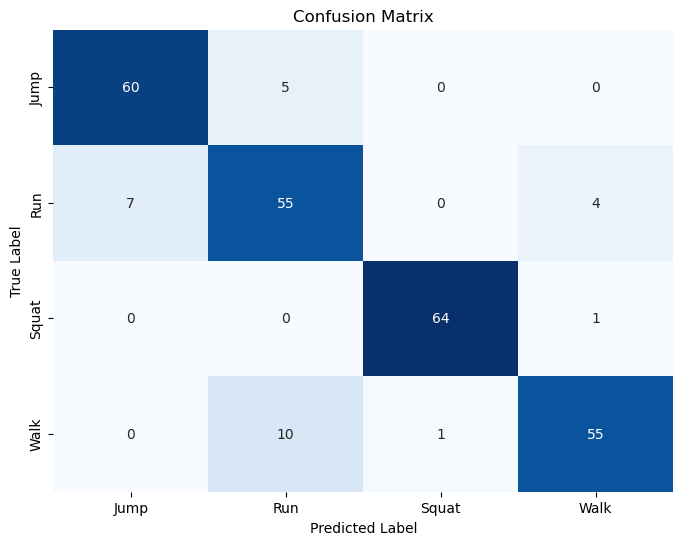

In [397]:
model_64_1_20, history_64_1_20, label_encoder_64_1_20 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=64,
    hidden_layers=1,
    timesteps=20
)
plot_training_history(
    history_64_1_20
)
evaluate_model(
    test_df=clean_test_df,
    model=model_64_1_20,
    label_encoder=label_encoder_64_1_20,
    timesteps=20
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_64_1_20,
    label_encoder=label_encoder_64_1_20,
    timesteps = 20
)

### 64 Neurons | 1 Hidden Layer | 30 Timesteps

Model: "sequential_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_GRU (GRU)      (None, 64)                13824     
                                                                 
 dropout_204 (Dropout)       (None, 64)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 260       
                                                                 
Total params: 14,084
Trainable params: 14,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
17/17 [==============================] - 3s 43ms/step - loss: 1.7067 - accuracy: 0.2691 - val_loss: 1.5723 - val_accuracy: 0.2529
Epoch 2/100
17/17 [==============================] - 0s 14ms/step - loss: 1.5285 - accuracy: 0.2615 - val_loss: 1.4877 - val_accuracy: 0.3046
Epoch 3/100
17/17 [=========

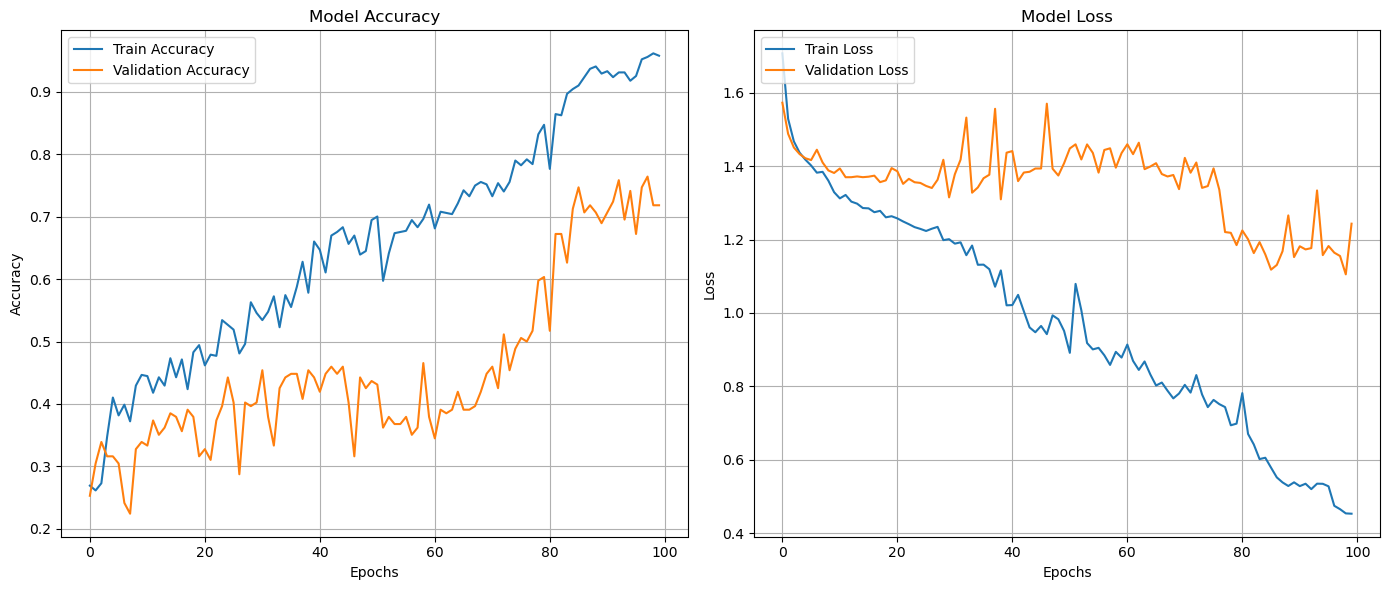

(5245, 6)
(5245,)
6/6 [==============================] - 0s 4ms/step - loss: 0.7302 - accuracy: 0.8391
Test Loss: 0.7302
Test Accuracy: 0.8391
6/6 [==============================] - 0s 4ms/step


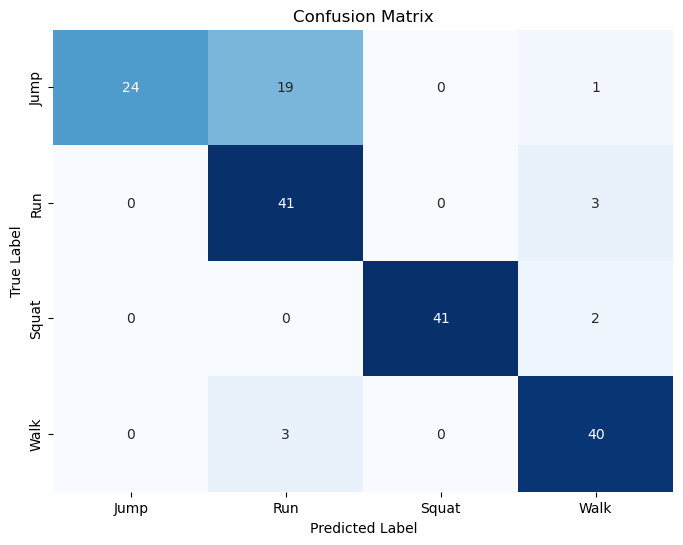

In [398]:
model_64_1_30, history_64_1_30, label_encoder_64_1_30 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=64,
    hidden_layers=1,
    timesteps=30
)
plot_training_history(
    history_64_1_30
)
evaluate_model(
    test_df=clean_test_df,
    model=model_64_1_30,
    label_encoder=label_encoder_64_1_30,
    timesteps=30
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_64_1_30,
    label_encoder=label_encoder_64_1_30,
    timesteps = 30
)

### 64 Neurons | 2 Hidden Layer | 10 Timesteps

Model: "sequential_151"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_2_GRU (GRU)    (None, 10, 64)            13824     
                                                                 
 dropout_205 (Dropout)       (None, 10, 64)            0         
                                                                 
 Hidden_layer_GRU (GRU)      (None, 64)                24960     
                                                                 
 dropout_206 (Dropout)       (None, 64)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 260       
                                                                 
Total params: 39,044
Trainable params: 39,044
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
50/50 [=============================

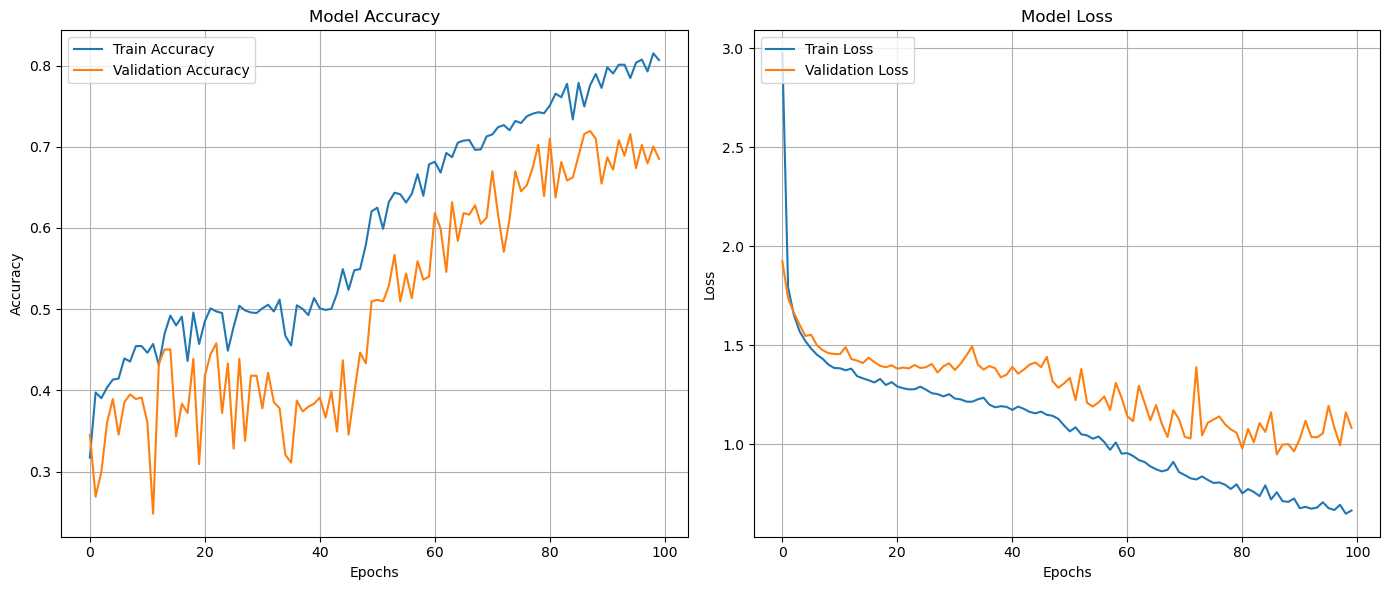

(5245, 6)
(5245,)
17/17 [==============================] - 0s 4ms/step - loss: 0.6677 - accuracy: 0.8111
Test Loss: 0.6677
Test Accuracy: 0.8111
17/17 [==============================] - 1s 3ms/step


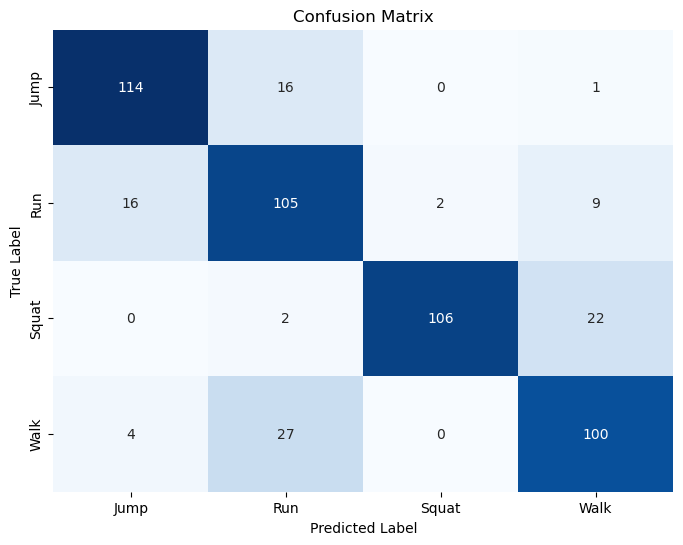

In [399]:
model_64_2_10, history_64_2_10, label_encoder_64_2_10 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=64,
    hidden_layers=2,
    timesteps=10
)
plot_training_history(
    history_64_2_10
)
evaluate_model(
    test_df=clean_test_df,
    model=model_64_2_10,
    label_encoder=label_encoder_64_2_10,
    timesteps=10
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_64_2_10,
    label_encoder=label_encoder_64_2_10,
    timesteps = 10
)

### 64 Neurons | 2 Hidden Layer | 20 Timesteps

Model: "sequential_152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_2_GRU (GRU)    (None, 20, 64)            13824     
                                                                 
 dropout_207 (Dropout)       (None, 20, 64)            0         
                                                                 
 Hidden_layer_GRU (GRU)      (None, 64)                24960     
                                                                 
 dropout_208 (Dropout)       (None, 64)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 260       
                                                                 
Total params: 39,044
Trainable params: 39,044
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [=============================

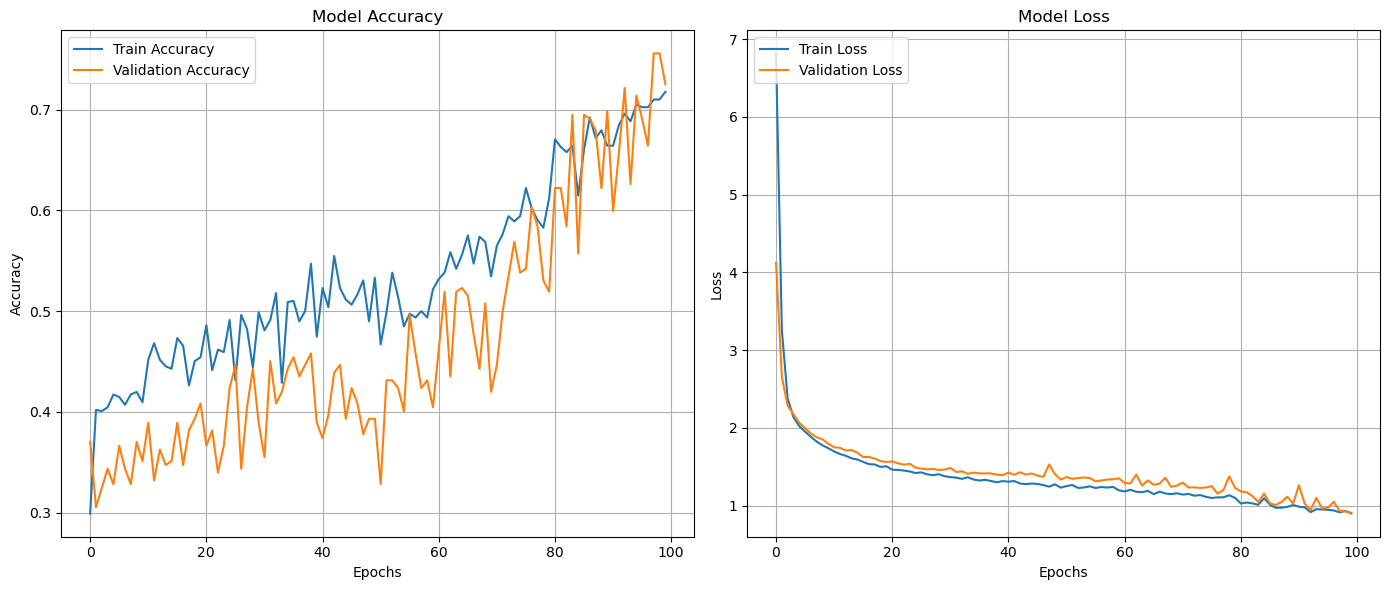

(5245, 6)
(5245,)
9/9 [==============================] - 0s 7ms/step - loss: 0.9861 - accuracy: 0.6603
Test Loss: 0.9861
Test Accuracy: 0.6603
9/9 [==============================] - 1s 7ms/step


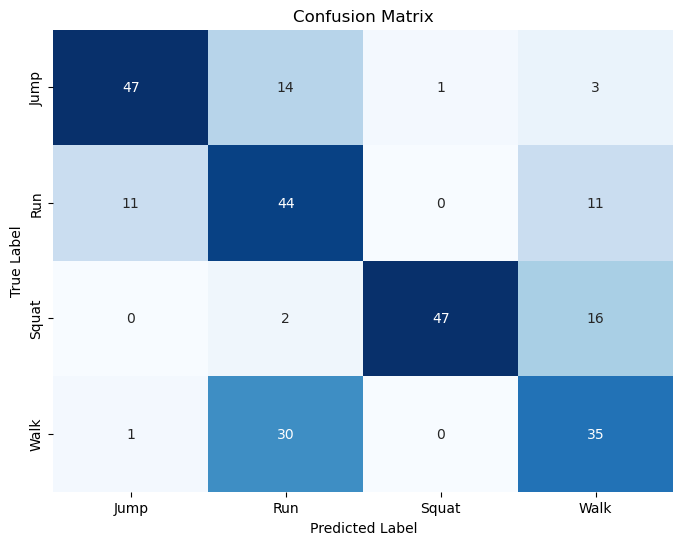

In [400]:
model_64_2_20, history_64_2_20, label_encoder_64_2_20 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=64,
    hidden_layers=2,
    timesteps=20
)
plot_training_history(
    history_64_2_20
)
evaluate_model(
    test_df=clean_test_df,
    model=model_64_2_20,
    label_encoder=label_encoder_64_2_20,
    timesteps=20
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_64_2_20,
    label_encoder=label_encoder_64_2_20,
    timesteps = 20
)

### 64 Neurons | 2 Hidden Layer | 30 Timesteps

Model: "sequential_153"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_2_GRU (GRU)    (None, 30, 64)            13824     
                                                                 
 dropout_209 (Dropout)       (None, 30, 64)            0         
                                                                 
 Hidden_layer_GRU (GRU)      (None, 64)                24960     
                                                                 
 dropout_210 (Dropout)       (None, 64)                0         
                                                                 
 Output_Layer (Dense)        (None, 4)                 260       
                                                                 
Total params: 39,044
Trainable params: 39,044
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
17/17 [=============================

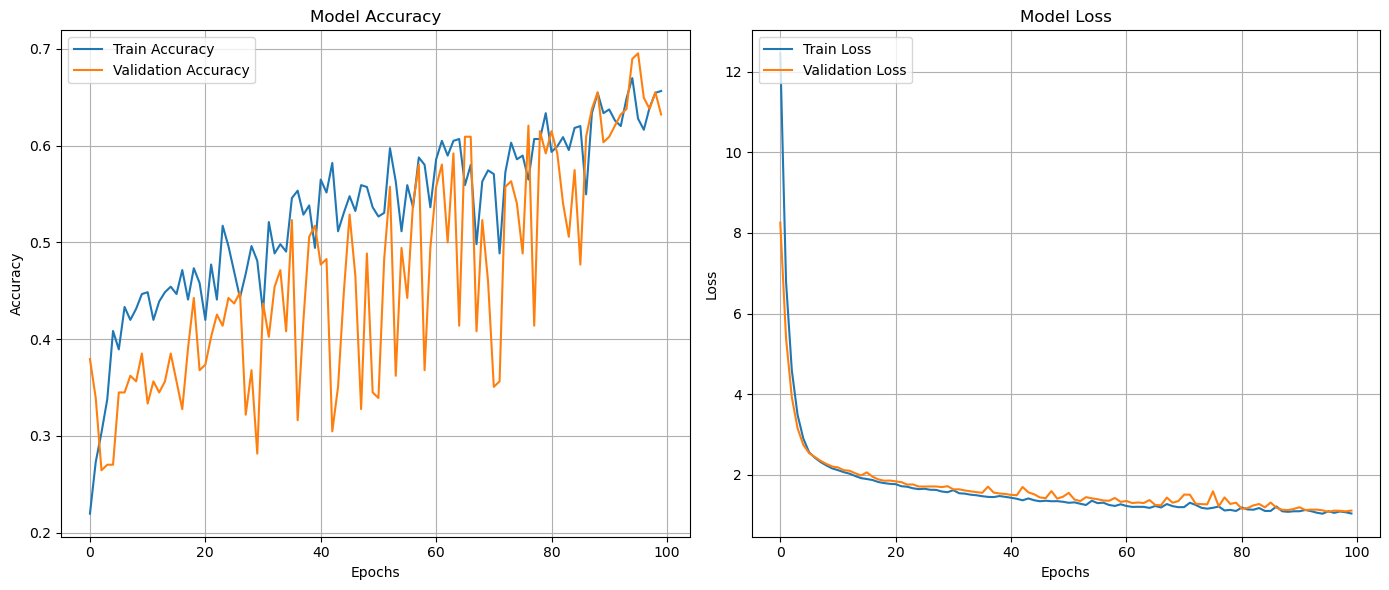

(5245, 6)
(5245,)
6/6 [==============================] - 0s 8ms/step - loss: 1.5828 - accuracy: 0.3966
Test Loss: 1.5828
Test Accuracy: 0.3966
6/6 [==============================] - 1s 10ms/step


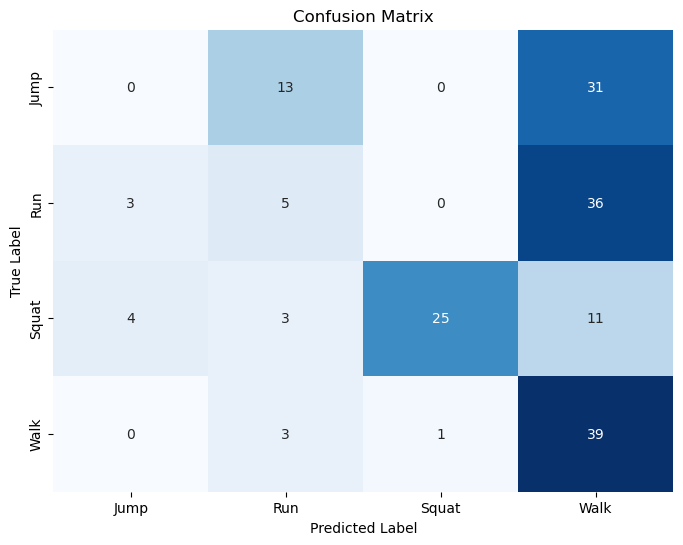

In [401]:
model_64_2_30, history_64_2_30, label_encoder_64_2_30 = train_gru_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=64,
    hidden_layers=2,
    timesteps=30
)
plot_training_history(
    history_64_2_30
)
evaluate_model(
    test_df=clean_test_df,
    model=model_64_2_30,
    label_encoder=label_encoder_64_2_30,
    timesteps=30
)
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_64_2_30,
    label_encoder=label_encoder_64_2_30,
    timesteps = 30
)